# Twitter Disaster Tweets check

Twitter has become an important communication channel in times of emergency.The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).  This notebook is a basic demonstration of the process used in classification of fake versus real disaster tweets.

**About Data:**

Files

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format
* Columns

Columns

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


**Target** :

To Predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.offline
import plotly.express as px
import plotly.graph_objects as go

#Natural Language Processing
#Data Manipulation and Cleaning
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string

#Modeling
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


# Loading Data

In [2]:
Train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


Creating Train copy to perform Exploratory Data Analysis

In [3]:
train = Train.copy()

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In the data the target column shows 1 for real disaster tweet and 0 for fake disaster tweet.

In [5]:
print('There are {} rows and {} columns in train'.format(train.shape[0], train.shape[1]))

There are 7613 rows and 5 columns in train


# Exploratory Data Analysis and Visualisation 

In [7]:
#Category counts for type of tweets
Category_count=np.array(train['target'].value_counts())
Tweet_type=sorted(train['target'].unique())

In [8]:
fig = go.Figure(data=[go.Pie(labels=Tweet_type, values=Category_count, hole=.3)])
fig.show()

The Donut chart shows that 57 % of the Disaster Tweets are Fake. Let's check the actual counts.

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

So the actual counts show that more than 4000+ Disasters tweets are fake and 3000+ disasters tweets are real. 

# Exploratory Data Analysis

Analysis on character level, word level and sentence level.

# **Number of characters in tweets**

In [10]:
#Adding lenght column to dataset
train['length']=train['text'].apply(len)
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [11]:
#checking length distribution
import plotly.express as px
fig = px.histogram(train, x="length", color="target")
fig.show()

# **Number of words in tweets**

In [12]:
train['word_count']=train['text'].str.split().map(lambda x: len(x))

In [13]:
import plotly.express as px
fig = px.histogram(train, x="word_count", color="target")
fig.show()

In [14]:
train.head()

,id,keyword,location,text,target,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


In [15]:
train.describe()

,id,target,length,word_count
count,7613.000000,7613.00000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.037436,14.903586
std,3137.116090,0.49506,33.781325,5.732604
min,1.000000,0.00000,7.000000,1.000000
25%,2734.000000,0.00000,78.000000,11.000000
50%,5408.000000,0.00000,107.000000,15.000000
75%,8146.000000,1.00000,133.000000,19.000000
max,10873.000000,1.00000,157.000000,31.000000


In [16]:
#Tweet with max length
train[train['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

In [17]:
train[train['length']==7]['text'].iloc[0]

'Crushed'

In [18]:
#Tweet with max word count
train[train['word_count']==31]['text'].iloc[0]

'If you have a son or a daughter would you like to see them going to a war with Iran and come back in a body bag? Let the #Republicans know'

In [19]:
train[train['word_count']==1]['text'].iloc[0]

'LOOOOOOL'

# **Average word length in a tweet**

In [20]:
avg_word_length=train['text'].str.split().apply(lambda x : [len(i) for i in x])
train['avg_word_length']=avg_word_length.map(lambda x: np.mean(x))

In [21]:
train.head()

,id,keyword,location,text,target,length,word_count,avg_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000


In [22]:
import plotly.express as px
fig = px.histogram(train, x="avg_word_length", color="target")
fig.show()

In [23]:
#Creating Tweet Corpus function
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus        

# **Common stopwords in tweets**

First we will analyze stopwords in real tweets

In [24]:
corpus = create_corpus(1)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]        

<BarContainer object of 10 artists>

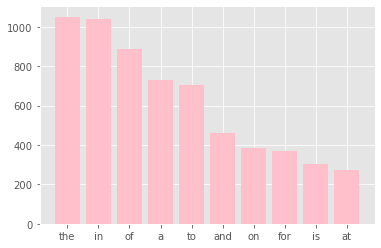

In [25]:
x,y = zip(*top)
plt.bar(x,y, color = 'pink')

Analyzing stopwords in Fake Tweets.

In [26]:
corpus = create_corpus(0)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]        

<BarContainer object of 10 artists>

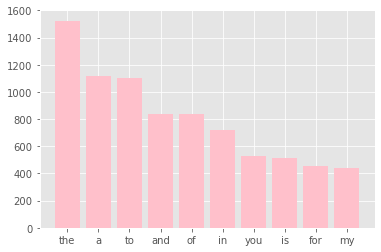

In [27]:
x,y = zip(*top)
plt.bar(x,y, color = 'pink')

# **Analyzing punctuations.**

First let's check tweets indicating real disaster tweets.

<BarContainer object of 18 artists>

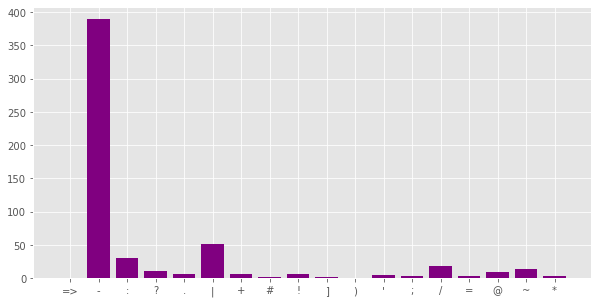

In [28]:
plt.figure(figsize = (10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color='purple')
        

Now we'll look at punctuations of fake tweets 

<BarContainer object of 20 artists>

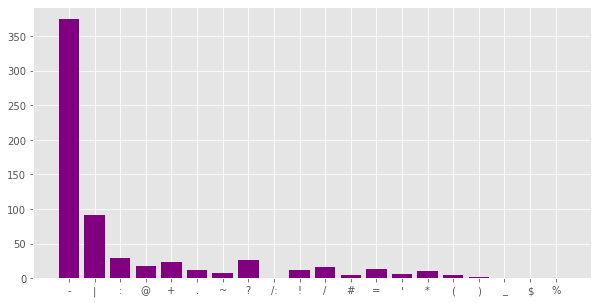

In [29]:
plt.figure(figsize = (10,5))
corpus = create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color = 'purple')
        

# **Analyzing Common words**

**Real Disaster Tweets**

In [30]:
corpus = create_corpus(1)
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

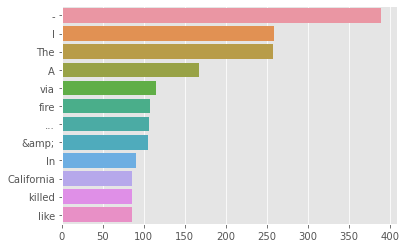

In [31]:
sns.barplot(x=y,y=x)

**Fake Disaster Tweets**

In [32]:
corpus = create_corpus(0)
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

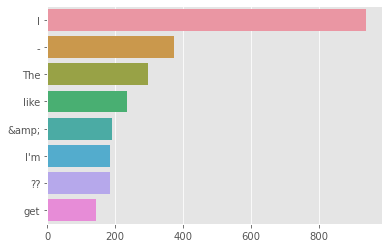

In [33]:
sns.barplot(x=y,y=x)

# **Ngram Analysis**

we will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets

In [34]:
def get_top_tweet_bigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range = (2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
    

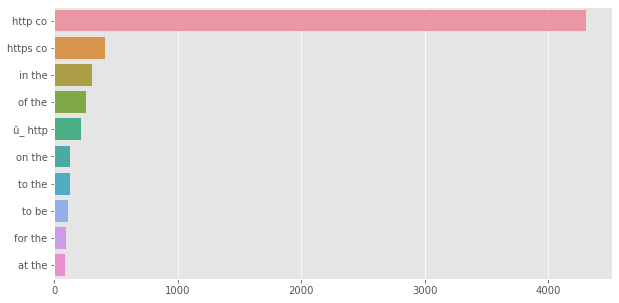

In [35]:
plt.figure(figsize = (10,5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]
x,y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)

# Data Cleaning

As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [36]:
df = pd.concat([Train,test])
df.shape

(10876, 5)

# **Removing URLs**

In [37]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [38]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
remove_URL(example)

'New competition launched :'

In [39]:
df['text'] = df['text'].apply(lambda x : remove_URL(x))

# Removing HTML tags

In [40]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [41]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [42]:
df['text']=df['text'].apply(lambda x : remove_html(x))

# Removing Emojis

In [43]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [44]:
df['text'] = df['text'].apply(lambda x : remove_emoji(x))

# Removing punctuations

In [45]:
def remove_punct(text):
    table = str.maketrans('','', string.punctuation)
    return text.translate(table)

example = "I am a #king"
print(remove_punct(example))

I am a king


In [46]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

# Glove for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [50]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus     

In [51]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:02<00:00, 3890.87it/s]


In [52]:
embedding_dict = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()        

In [53]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen = MAX_LEN, truncating = 'post', padding = 'post')

In [54]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

Number of unique words: 20342


In [55]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 100))
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
        
    emb_vec = embedding_dict.get(word)   
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 324275.81it/s]


# Baseline Model using LSTM

In [56]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [58]:
train_ = tweet_pad[:train.shape[0]]
test = tweet_pad[train.shape[0]:]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train_,train['target'].values, test_size = 0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [61]:
history = model.fit(X_train,y_train, batch_size = 4, epochs =15, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/15
1618/1618 - 325s - loss: 0.6905 - accuracy: 0.5704 - val_loss: 0.6861 - val_accuracy: 0.5701
Epoch 2/15
1618/1618 - 323s - loss: 0.6313 - accuracy: 0.6324 - val_loss: 0.5716 - val_accuracy: 0.7671
Epoch 3/15
1618/1618 - 321s - loss: 0.5712 - accuracy: 0.7483 - val_loss: 0.5419 - val_accuracy: 0.7636
Epoch 4/15
1618/1618 - 326s - loss: 0.5446 - accuracy: 0.7548 - val_loss: 0.5233 - val_accuracy: 0.7680
Epoch 5/15
1618/1618 - 327s - loss: 0.5268 - accuracy: 0.7591 - val_loss: 0.5106 - val_accuracy: 0.7697
Epoch 6/15
1618/1618 - 322s - loss: 0.5145 - accuracy: 0.7673 - val_loss: 0.5013 - val_accuracy: 0.7776
Epoch 7/15
1618/1618 - 326s - loss: 0.5036 - accuracy: 0.7721 - val_loss: 0.4945 - val_accuracy: 0.7785
Epoch 8/15
1618/1618 - 325s - loss: 0.4994 - accuracy: 0.7755 - val_loss: 0.4905 - val_accuracy: 0.7793
Epoch 9/15
1618/1618 - 326s - loss: 0.4907 - accuracy: 0.7784 - val_loss: 0.4867 - val_accuracy: 0.7785
Epoch 10/15
1618/1618 - 327s - loss: 0.4863 - accuracy: 0.7789 -

so, we have got 78% accuracy using LSTM Baseline Model

# Making our submission

In [62]:
sample_sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [63]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [64]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Please upvote my work if it could help! Thank you!